# NLP: Product Comment Sentiment Analysis

**Resources**
*   https://www.geeksforgeeks.org/what-is-sentiment-analysis/ (intro)
*   tutorial (https://www.datacamp.com/tutorial/text-analytics-beginners-nltk)
*   https://youtu.be/9p1KYtYAus8 & https://youtu.be/QpzMWQvxXWk?feature=shared (vader lexicon tutorial - for sentiment analysis)
*   dataset downloaded from https://www.kaggle.com/datasets/mdwaquarazam/headphone-dataset-review-analysis

<br><br>

Documents (bg study, methods etc will do later)

> Step 1: Get data (csv file)

> Step 2: Pre-processing. Tokenize, Lemmatize, remove stopwords, punctuations etc, then do sentiment analysis

> Step 3: Count vectorizer (frequency each words appeared), then identify similarity (use cosine similarity equation, correlation etc.)

> Step 4: each of us will choose our preferred method (bayes, knn, k-means)

> Step 5: compare the results (from using different methods)







# Getting Data & Setup


In [31]:
# install nltk (terminal line commands)
# %pip install --upgrade pip # ensure pip installer is 
%pip install nltk
%pip install pandas
%pip install -U scikit-learn

import nltk
import math
import site
import pandas as pd    # to allow us to read csv file
import random
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns # couldn't find module
#import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize # for tokenization of words
from nltk.stem import WordNetLemmatizer # for lemmatization
from sklearn.metrics import confusion_matrix # confusion matrix (evaluate performance of nltk sentiment analyzer)
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import naive_bayes
import math
from sklearn.preprocessing import LabelEncoder

plt.style.use('ggplot')
nltk.download('all')
site.getsitepackages() # to find our current path, we imported site, and getsitepackages()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

['c:\\Users\\User\\anaconda3',
 'c:\\Users\\User\\anaconda3\\Lib\\site-packages']

# Read data

In [32]:
data = pd.read_csv('AllProductReviews.csv')
# nrows is to limit the data rows that we wanted to take out
# data = pd.read_csv('AllProductReviews.csv', nrows=3000) 

In [33]:
# data.head()
total = data.count()
print(total)

ReviewTitle    14337
ReviewBody     14337
ReviewStar     14337
Product        14337
dtype: int64


Shows the Ratings by the reviewers

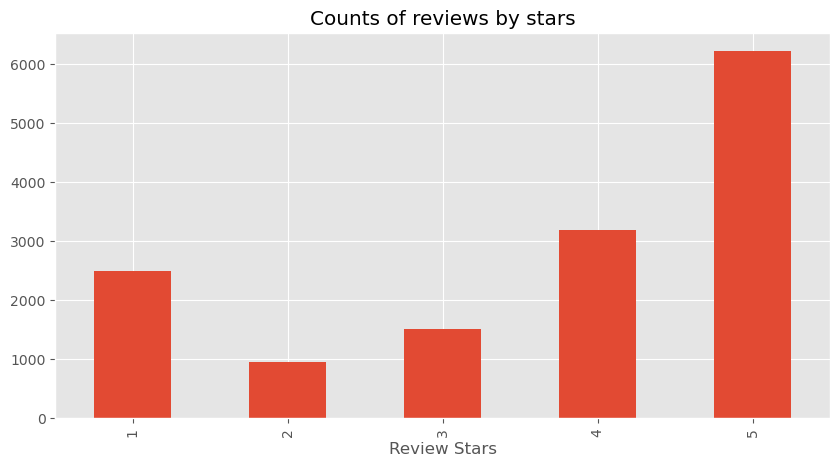

In [34]:
# to indicate how many rating is occupied
ax = data['ReviewStar'].value_counts().sort_index().plot(kind='bar', title= 'Counts of reviews by stars', figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show() # show bar chart

# Pre-Processing

In [35]:
# create pre processing function
def preprocess_data(text):

  # tokenize the text (and make it lowercase)
  tokens = word_tokenize(text.lower())

  # remove stop words
  filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

  # lemmatize the tokens
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  #Join the tokens back into a string
  processed_text = ' '.join(lemmatized_tokens)

  return processed_text


# remove punctuations from data
data['ReviewBody'].dropna(inplace=True)
data['ReviewBody'] = data['ReviewBody'].astype(str) # convert data to 'string' data type

# Preprocess_data
# create a column called 'tokenized'
data['Processed'] = data.apply(lambda x: preprocess_data(x['ReviewBody']), axis=1) # applying the preprocess_data function to the 'COMMENTS' column of  the DataFrame
data # display resulting table

,ReviewTitle,ReviewBody,ReviewStar,Product,Processed
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255,doubt great bass great extent noise cancellati...
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255,"earphone unreliable , bought 15 day meanwhile ..."
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255,"bought itfor 999 , purchased second time , gif..."
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255,sound quality adorable . overall good 2 week s...
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255,awesome ... good sound quality & 8-9 hr batter...
...,...,...,...,...,...
14332,Good\n,Good\n,4,JBL T110BT,good
14333,Amazing Product\n,An amazing product but a bit costly.\n,5,JBL T110BT,amazing product bit costly .
14334,Not bad\n,Sound\n,1,JBL T110BT,sound
14335,a good product\n,the sound is good battery life is good but the...,5,JBL T110BT,sound good battery life good wire long 's good...


# Sentiment Analysis

In [36]:
# creating NLTK sentiment analyzer (via nltk.sentiment.vader library)
analyzer = SentimentIntensityAnalyzer()

# create get_positive_score function
def get_positive_score(text):
    # take text string as input, get sentiment scores pos/neg/neutral (dictionary data type {key:value}) using polarity_scores method
    # polarity score includes score for pos, neg, and neutral (assign sentiment value depending on whether positive score is +ve or - ve, values above 0 classified positive)

    scores = analyzer.polarity_scores(text) # sentiment scores (pos, neg, neutral) parse as dictionary type into scores (accessed later as scores[key])
    positive_score = math.ceil(scores['pos']) # ceil() rounds score to the next greater nearest integer. E.g 0.201 round to 1, -0.2 round to 0

    return positive_score

# create get_sentiment function
def get_sentiment(text):

    scores = analyzer.polarity_scores(text) # sentiment scores (pos, neg, neutral) parse as dictionary type into scores (accessed later as scores[key])
    sentiment = 1 if scores['pos'] > 0 else 0 # assign sentiment score based on text's POSITIVE score 
   
    return sentiment

 # create new column called 'Positive' and apply get_sentiment function
data['Polarity'] = data['ReviewBody'].apply(get_positive_score)

# create new column called 'sentiment' and apply get_sentiment function
data['Sentiment'] = data['ReviewBody'].apply(get_sentiment) # applying the get_sentiment function to each value in the 'COMMENTS' column (row by row)


data # display table





,ReviewTitle,ReviewBody,ReviewStar,Product,Processed,Polarity,Sentiment
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255,doubt great bass great extent noise cancellati...,1,1
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255,"earphone unreliable , bought 15 day meanwhile ...",1,1
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255,"bought itfor 999 , purchased second time , gif...",1,1
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255,sound quality adorable . overall good 2 week s...,1,1
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255,awesome ... good sound quality & 8-9 hr batter...,1,1
...,...,...,...,...,...,...,...
14332,Good\n,Good\n,4,JBL T110BT,good,1,1
14333,Amazing Product\n,An amazing product but a bit costly.\n,5,JBL T110BT,amazing product bit costly .,1,1
14334,Not bad\n,Sound\n,1,JBL T110BT,sound,0,0
14335,a good product\n,the sound is good battery life is good but the...,5,JBL T110BT,sound good battery life good wire long 's good...,1,1


Encoding to convert from char to numeric and split it into train machine and testing

In [70]:
# train the machine to distinguish the positive and negative rating based on the tokens
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(data['Sentiment']) # convert to numeric form
train_sentences, test_sentences, train_labels, test_labels = train_test_split(data['Processed'], encoded_labels, stratify = encoded_labels, test_size = 0.3, random_state = 42)

Naive Bayes

In [82]:
# naive bayes classifier
vector = CountVectorizer(max_features = 600) # features or input (200 means 200 common words are selected)
train_transData = vector.fit_transform(train_sentences) # transform parameter on the training data and transform the input by using learned parameter
test_transData = vector.fit_transform(test_sentences)
# print(train_transData)

Naive = naive_bayes.MultinomialNB()
Naive.fit(train_transData,train_labels)
predictions_NB = Naive.predict(test_transData)

# Use accuracy_score function to get the accuracy

print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, test_labels)*100)
print("Naive Bayes classification report \n", classification_report(test_labels, predictions_NB))


Naive Bayes Accuracy Score ->  75.38354253835425
Naive Bayes classification report 
               precision    recall  f1-score   support

           0       0.41      0.06      0.10      1032
           1       0.77      0.97      0.86      3270

    accuracy                           0.75      4302
   macro avg       0.59      0.52      0.48      4302
weighted avg       0.68      0.75      0.68      4302



In [26]:
# check performance of sentiment analyzer

# confusion_matrix is a function evaluates the performance of a classification model by comparing the predicted labels with the actual labels (pass two arguments, data['Positive'] and data['Sentiment'].)
# shows the number of true positives, false positives, true negatives, and false negatives (The rows of the matrix represent the actual labels, while the columns represent the predicted labels)
# diagonal elements of the matrix represent the number of correct predictions, while the off-diagonal elements represent the number of incorrect predictions.

print(confusion_matrix(data['Positive'], data['Sentiment'])) 
print("_______" * 8)
print(classification_report(data['Positive'], data['Sentiment']))

[[ 540    0]
 [   0 1064]]
________________________________________________________
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       540
           1       1.00      1.00      1.00      1064

    accuracy                           1.00      1604
   macro avg       1.00      1.00      1.00      1604
weighted avg       1.00      1.00      1.00      1604

